# Test QAOA with 3 qubit problem on simulator and real device.
We will create the ideal circuit with the help of IBMQ by using QAOA in qiskit terra.
Then we transpile the circuit to be used on real device.
For both we will show the measurement outcome.


In [1]:
import numpy as np 
from numpy import pi
import matplotlib.pyplot as plt
import networkx as nx

from qiskit import IBMQ, QuantumRegister, ClassicalRegister, QuantumCircuit, execute, transpile, BasicAer
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq.job import job_monitor
from qiskit.providers.ibmq import least_busy

from utilities.helpers import create_qaoa_meo

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
shots = 4096

In [3]:
# select linear program to solve
qp = QuadraticProgram()
qp.read_from_lp_file("example.lp")
# solve classically as reference
cplex = CplexOptimizer()
print(cplex.solve(qp))
print(qp)

optimal function value: -3.0
optimal value: [1. 1. 1.]
status: SUCCESS
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: example_qp

Minimize
 obj: - x_0 - x_2 + [ - 2 x_0^2 + 2 x_0*x_2 - 4 x_2*x_1 + 2 x_1^2 ]/2
Subject To
 A0_eq_b0: - x_2 + x_1 = 0

Bounds
 0 <= x_0 <= 1
 0 <= x_2 <= 1
 0 <= x_1 <= 1

Binaries
 x_0 x_2 x_1
End



In [10]:
# solve qp with Minimum Eigen Optimizer QAOA and online simulator
EVALUATIONS = 20
def qaoa_callback(eval_ct: int, opt_pars: np.ndarray, mean: float, stdev: float) -> None:
    """Print parameterset of last iteration."""
    if eval_ct == EVALUATIONS:
        print("Evaluation count reached ", eval_ct, "with pars:", opt_pars)
ibmq = IBMQ.get_provider(hub='ibm-q').get_backend('ibmq_qasm_simulator')
qaoa = create_qaoa_meo(backend=ibmq, max_iter=EVALUATIONS, qaoa_callback=qaoa_callback)
res = qaoa.solve(qp)
res

Evaluation count: 20  pars: [-0.17109735  0.40986404]


optimal function value: -3.0
optimal value: [1. 1. 1.]
status: SUCCESS

In [5]:
def create_qaoa_circuit() -> QuantumCircuit:
    """ taken from IBMQ Experience """
    qreg_q = QuantumRegister(3, 'q')
    circuit = QuantumCircuit(qreg_q)

    circuit.h(qreg_q[0])
    circuit.h(qreg_q[1])
    circuit.cx(qreg_q[1], qreg_q[0])
    circuit.rz(-0.06942544294642758, qreg_q[0])
    circuit.cx(qreg_q[1], qreg_q[0])
    circuit.rz(-0.20827632883928274, qreg_q[0])
    circuit.rx(0.7530122052855767, qreg_q[0])
    circuit.h(qreg_q[2])
    circuit.cx(qreg_q[2], qreg_q[1])
    circuit.rz(1.2496579730356965, qreg_q[1])
    circuit.cx(qreg_q[2], qreg_q[1])
    circuit.rz(-0.20827632883928274, qreg_q[1])
    circuit.rx(0.7530122052855767, qreg_q[1])
    circuit.rx(0.7530122052855767, qreg_q[2])
    
    circuit.measure_all()
    return circuit

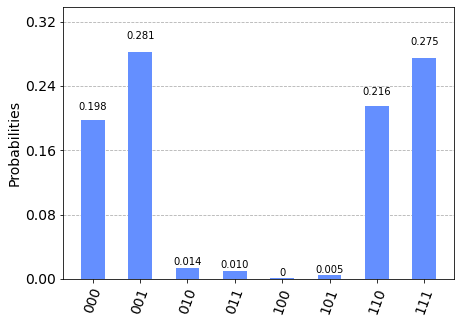

In [10]:
circuit = create_qaoa_circuit()
result_meas = execute(circuit, BasicAer.get_backend('qasm_simulator'), shots=shots)
counts = result_meas.result().get_counts()
plot_histogram(counts)

In [11]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3
                                    and not x.configuration().simulator
                                    and x.status().operational==True))
print(backend)

ibmq_belem


In [12]:
job = execute(circuit, backend, shots=shots, job_name="qaoa_3_real", job_tags=["qaoa", "least busy"])
job_monitor(job)

Job Status: job has successfully run                          


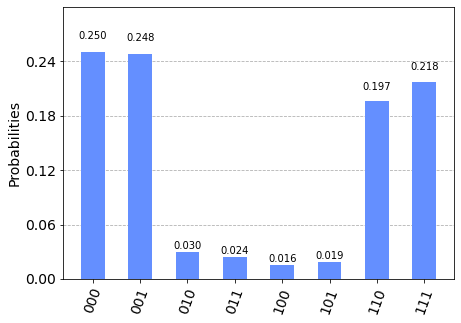

In [13]:
counts = job.result().get_counts()
plot_histogram(counts)